# Parameter sweep for LBI predictor with mutation frequencies

Load flu tip attributes and final clade frequencies and then calculate the error of an exponential growth model based on just the LBI predictor across a range of predictor coefficients. The goal is to determine the shape of the error function that is exposed to scipy's optimization machinery.

In [190]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

%matplotlib inline

plt.style.use("huddlej")

In [191]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [192]:
sys.path.insert(0, "../src")

In [193]:
from fit_model import ExponentialGrowthModel
from forecast.metrics import mean_absolute_error, sum_of_squared_errors, negative_information_gain, add_pseudocounts_to_frequencies

## Define model subclass for mutation targets

In [194]:
class MutationExponentialGrowthModel(ExponentialGrowthModel):
    def _fit(self, coefficients, X_tips, y, X_mutations):
        # Estimate final frequencies.
        y_hat = self.predict(X_tips, X_mutations, coefficients)

        # Merge estimated and observed frequencies. The left join enables
        # tracking of clades that die in the future and are therefore not
        # observed in the future frequencies data frame.
        frequencies = y_hat.merge(
            y,
            how="left",
            on=["timepoint", "mutation"],
            suffixes=["_estimated", "_observed"]
        )
        frequencies["frequency_observed"] = frequencies["frequency_observed"].fillna(0.0)

        # Calculate initial frequencies for use by cost function.
        initial_frequencies = X_mutations.groupby([
            "timepoint",
            "mutation"
        ])["frequency"].sum().reset_index()

        # Annotate future frequencies with initial frequencies.
        frequencies = frequencies.merge(
            initial_frequencies,
            how="inner",
            on=["timepoint", "mutation"]
        )

        # Calculate the error between the observed and estimated frequencies.
        error = self.cost_function(
            frequencies["frequency_observed"],
            frequencies["frequency_estimated"],
            initial=frequencies["frequency"]
        )
        l1_penalty = self.l1_lambda * np.abs(coefficients).sum()
        
        return error + l1_penalty
    
    def predict(self, X_tips, X_mutations, coefficients=None):
        # Use model coefficients, if none are provided.
        if coefficients is None:
            coefficients = self.coef_

        estimated_frequencies = []
        for timepoint, timepoint_df in X_tips.groupby("timepoint"):
            # Select predictors from the timepoint.
            predictors = timepoint_df.loc[:, self.predictors].values

            # Select frequencies from timepoint.
            initial_frequencies = timepoint_df["frequency"].values

            # Calculate fitnesses.
            fitnesses = self.get_fitnesses(coefficients, predictors)

            # Project frequencies.
            projected_frequencies = self.project_frequencies(
                initial_frequencies,
                fitnesses,
                self.delta_time
            )

            projected_timepoint_df = timepoint_df[["timepoint", "strain"]].copy()
            projected_timepoint_df["frequency"] = projected_frequencies
            
            # Sum the estimated frequencies by mutation.
            timepoint_mutations = X_mutations[X_mutations["timepoint"] == timepoint].copy()
            annotated_timepoint_mutations = timepoint_mutations.merge(
                projected_timepoint_df,
                on=["timepoint", "strain"],
                suffixes=["_initial", ""]
            )
            
            projected_mutation_frequencies = annotated_timepoint_mutations.groupby([
                "timepoint",
                "mutation"
            ])["frequency"].sum().reset_index()

            estimated_frequencies.append(projected_mutation_frequencies)
            
        # Collect all estimated frequencies by timepoint.
        estimated_frequencies = pd.concat(estimated_frequencies)
        return estimated_frequencies

## Load data

Define the range of possible coefficient values to explore.

In [195]:
coefficients = np.linspace(-3, 3, 21)

In [196]:
delta_time = 1.0
l1_lambda = 0.0

In [197]:
last_timepoint = pd.to_datetime("2012-10-01")

In [198]:
# Load tip attributes.
X = pd.read_csv(
    "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/standardized_tip_attributes.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [199]:
X = X.loc[:, ["strain", "clade_membership", "timepoint", "cTiterSub_x", "lbi", "ep", "ep_x", "ne", "delta_frequency", "frequency"]].copy()

In [200]:
X = X[X["timepoint"] <= last_timepoint]

In [201]:
X.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency
0,A/BacGiang/BG003/2004,4ff1302,2004-10-01,NaN,-0.947616,10,2.115938,6,-0.918187,0.001207
1,A/California/7/2004,7aa732d,2004-10-01,-6.794363,1.584951,14,2.780779,7,0.753406,0.013619
2,A/California/NHRC0002/2003,4ff1302,2004-10-01,NaN,0.142304,10,2.139431,6,-0.918187,0.000005
3,A/Canterbury/100/2004,7aa732d,2004-10-01,-6.794363,1.771209,11,2.300266,7,0.753406,0.014974
4,A/Canterbury/20/2004,7aa732d,2004-10-01,-6.794363,2.178898,11,2.300266,7,0.753406,0.018538


In [202]:
X.shape

(3361, 10)

In [203]:
# Load final clade tip frequencies.
X_mutations = pd.read_csv(
    "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/mutation_frequencies_by_tip.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [204]:
X_mutations = X_mutations[X_mutations["timepoint"] <= last_timepoint]

In [259]:
X_mutations.shape

(486305, 6)

In [205]:
X_mutations.head()

,residue,site,strain,mutation,timepoint,frequency
0,P,HA1:103,A/HongKong/HKU2/2004,HA1:103P,2004-10-01,0.001207
1,Y,HA1:105,A/HongKong/HKU2/2004,HA1:105Y,2004-10-01,0.001207
2,N,HA1:121,A/HongKong/HKU2/2004,HA1:121N,2004-10-01,0.001207
3,S,HA1:124,A/HongKong/HKU2/2004,HA1:124S,2004-10-01,0.001207
4,D,HA1:126,A/HongKong/HKU2/2004,HA1:126D,2004-10-01,0.001207


In [248]:
max_frequency_by_timepoint_and_site = X_mutations.groupby(["timepoint", "site", "residue", "mutation"])["frequency"].sum().reset_index().groupby(
    ["timepoint", "site"]
).max().reset_index()

In [253]:
max_frequency_by_timepoint_and_site.shape

(2098, 5)

In [256]:
sites_to_keep = max_frequency_by_timepoint_and_site.loc[max_frequency_by_timepoint_and_site["frequency"] < 0.90, ["timepoint", "site"]].drop_duplicates()

In [261]:
X_mutations_filtered = X_mutations.merge(sites_to_keep)

In [262]:
X_mutations_filtered.shape

(31679, 6)

In [206]:
y = X_mutations.copy()

In [207]:
y["final_timepoint"] = y["timepoint"]

In [208]:
y["timepoint"] = y["final_timepoint"] - pd.DateOffset(months=12)

In [209]:
y.head()

,residue,site,strain,mutation,timepoint,frequency,final_timepoint
0,P,HA1:103,A/HongKong/HKU2/2004,HA1:103P,2003-10-01,0.001207,2004-10-01
1,Y,HA1:105,A/HongKong/HKU2/2004,HA1:105Y,2003-10-01,0.001207,2004-10-01
2,N,HA1:121,A/HongKong/HKU2/2004,HA1:121N,2003-10-01,0.001207,2004-10-01
3,S,HA1:124,A/HongKong/HKU2/2004,HA1:124S,2003-10-01,0.001207,2004-10-01
4,D,HA1:126,A/HongKong/HKU2/2004,HA1:126D,2003-10-01,0.001207,2004-10-01


In [210]:
y = y.groupby([
    "timepoint",
    "mutation"
])["frequency"].sum().reset_index()

y = y[y["timepoint"] <= last_timepoint]

In [211]:
y.head(10)

,timepoint,mutation,frequency
0,2003-10-01,HA1:103P,0.980490
1,2003-10-01,HA1:103Q,0.019513
2,2003-10-01,HA1:105H,0.014087
3,2003-10-01,HA1:105Y,0.985916
4,2003-10-01,HA1:121N,0.979939
5,2003-10-01,HA1:121S,0.020064
6,2003-10-01,HA1:124N,0.020989
7,2003-10-01,HA1:124S,0.979014
8,2003-10-01,HA1:126D,0.075270
9,2003-10-01,HA1:126N,0.924733


In [212]:
y.groupby("timepoint")["frequency"].sum()

timepoint
2003-10-01     75.000225
2004-04-01     78.999842
2004-10-01     59.999820
2005-04-01     76.999538
2005-10-01     58.999823
2006-04-01     93.000279
2006-10-01    132.999468
2007-04-01    117.000234
2007-10-01    104.000000
2008-04-01    120.000120
2008-10-01    140.001120
2009-04-01    133.999330
2009-10-01    173.000346
2010-04-01    197.997624
2010-10-01    141.998296
2011-04-01    202.003434
2011-10-01    191.999040
Name: frequency, dtype: float64

In [213]:
X.shape

(3361, 10)

In [214]:
X_mutations.shape

(486305, 6)

In [215]:
y.shape

(4763, 3)

In [216]:
X["timepoint"].unique().shape

(17,)

In [217]:
X_mutations["timepoint"].unique().shape

(17,)

In [218]:
y["timepoint"].unique().shape

(17,)

## Inspect LBI model

In [263]:
predictors = ["lbi"]
model = MutationExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

Calculate error for an LBI model across all coefficients.

In [264]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y, X_mutations_filtered)
    errors.append(error)

In [265]:
coefficients[np.argmin(errors)]

0.0

Text(0,0.5,'SSE')

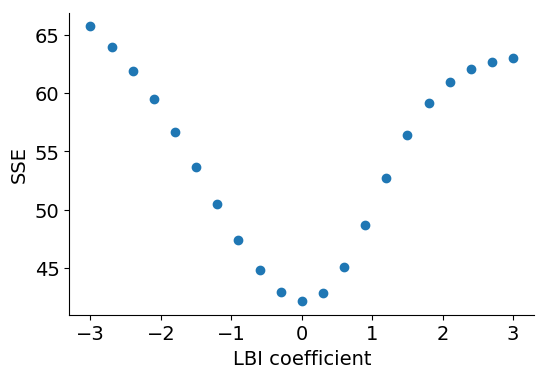

In [266]:
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

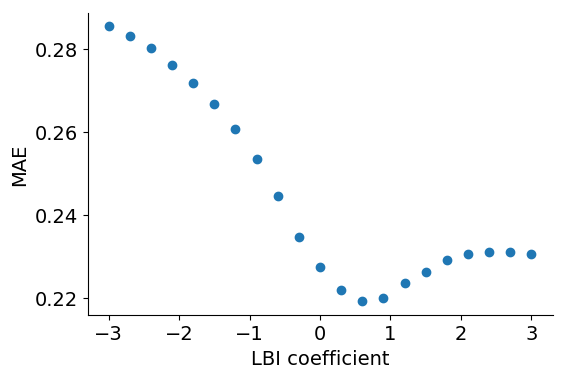

In [267]:
predictors = ["lbi"]
model = MutationExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y, X_mutations_filtered)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("MAE")

Text(0,0.5,'Negative information gain')

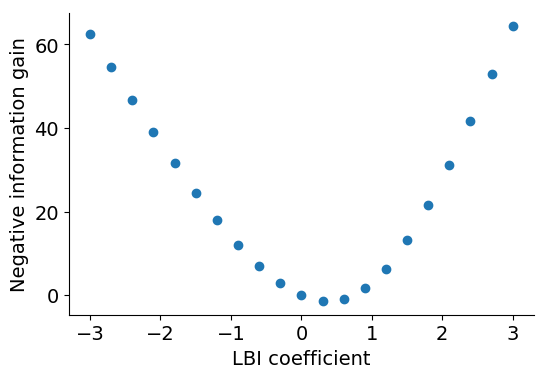

In [268]:
predictors = ["lbi"]
model = MutationExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y, X_mutations_filtered)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("Negative information gain")

In [269]:
np.min(errors)

-1.4026859723872258

In [270]:
coefficients[np.argmin(errors)]

0.2999999999999998

In [159]:
X_mutations.head()

,residue,site,strain,mutation,timepoint,frequency
0,P,HA1:103,A/HongKong/HKU2/2004,HA1:103P,2004-10-01,0.001207
1,Y,HA1:105,A/HongKong/HKU2/2004,HA1:105Y,2004-10-01,0.001207
2,N,HA1:121,A/HongKong/HKU2/2004,HA1:121N,2004-10-01,0.001207
3,S,HA1:124,A/HongKong/HKU2/2004,HA1:124S,2004-10-01,0.001207
4,D,HA1:126,A/HongKong/HKU2/2004,HA1:126D,2004-10-01,0.001207


In [160]:
observed_mutations = X_mutations.groupby(["timepoint", "site", "residue", "mutation"])["frequency"].sum().reset_index()

In [161]:
observed_mutations.head()

,timepoint,site,residue,mutation,frequency
0,2004-10-01,HA1:103,P,HA1:103P,0.980490
1,2004-10-01,HA1:103,Q,HA1:103Q,0.019513
2,2004-10-01,HA1:105,H,HA1:105H,0.014087
3,2004-10-01,HA1:105,Y,HA1:105Y,0.985916
4,2004-10-01,HA1:121,N,HA1:121N,0.979939


In [231]:
predicted_mutations = model.predict(X, X_mutations, np.array([-0.6]))

In [232]:
predicted_mutations.head()

,timepoint,mutation,frequency
0,2004-10-01,HA1:103P,0.986812
1,2004-10-01,HA1:103Q,0.013188
2,2004-10-01,HA1:105H,0.009310
3,2004-10-01,HA1:105Y,0.990690
4,2004-10-01,HA1:121N,0.986089


In [233]:
predicted_mutations["final_timepoint"] = predicted_mutations["timepoint"] + pd.DateOffset(months=12)

In [234]:
predicted_mutations = predicted_mutations.drop(columns=["timepoint"])

In [235]:
observed_and_predicted_mutations = observed_mutations.merge(
    predicted_mutations,
    left_on=["timepoint", "mutation"],
    right_on=["final_timepoint", "mutation"],
    suffixes=["_observed", "_estimated"]
)

In [236]:
sites_to_plot = ["HA1:144", "HA1:193"]

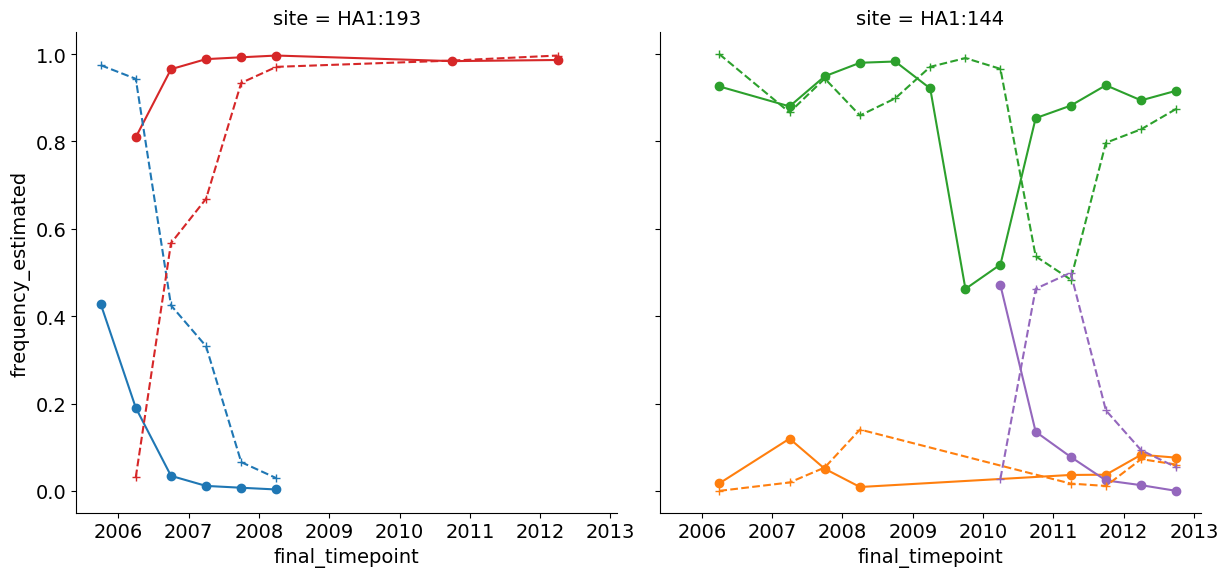

In [237]:
g = sns.FacetGrid(observed_and_predicted_mutations[observed_and_predicted_mutations["site"].isin(sites_to_plot)],
                  hue="residue", col="site", col_wrap=4, height=6)
g.map(plt.plot, "timepoint", "frequency_observed", marker="o")
g.map(plt.plot, "final_timepoint", "frequency_estimated", marker="+", linestyle="--")

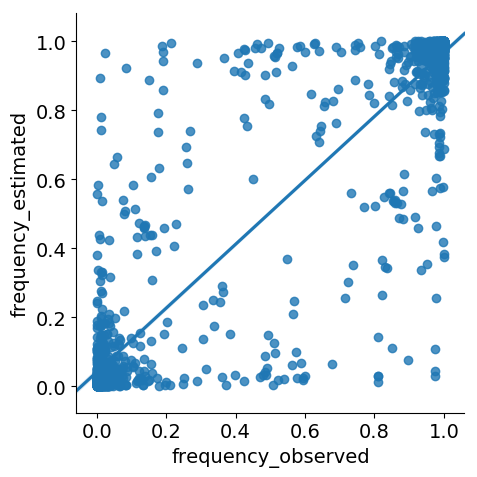

In [238]:
sns.lmplot("frequency_observed", "frequency_estimated", observed_and_predicted_mutations)

In [177]:
predicted_mutations = model.predict(X, X_mutations, np.array([0.0]))

In [178]:
predicted_mutations["final_timepoint"] = predicted_mutations["timepoint"] + pd.DateOffset(months=12)

In [179]:
predicted_mutations = predicted_mutations.drop(columns=["timepoint"])

In [180]:
predicted_mutations.head()

,mutation,frequency,final_timepoint
0,HA1:103P,0.980487,2005-10-01
1,HA1:103Q,0.019513,2005-10-01
2,HA1:105H,0.014087,2005-10-01
3,HA1:105Y,0.985913,2005-10-01
4,HA1:121N,0.979936,2005-10-01


In [181]:
observed_and_predicted_mutations = observed_mutations.merge(
    predicted_mutations,
    left_on=["timepoint", "mutation"],
    right_on=["final_timepoint", "mutation"],
    suffixes=["_observed", "_estimated"]
)

In [182]:
observed_and_predicted_mutations.head()

,timepoint,site,residue,mutation,frequency_observed,frequency_estimated,final_timepoint
0,2005-10-01,HA1:124,N,HA1:124N,0.025933,0.020989,2005-10-01
1,2005-10-01,HA1:124,S,HA1:124S,0.974030,0.979011,2005-10-01
2,2005-10-01,HA1:138,A,HA1:138A,0.970997,0.912624,2005-10-01
3,2005-10-01,HA1:138,S,HA1:138S,0.029000,0.087376,2005-10-01
4,2005-10-01,HA1:145,K,HA1:145K,0.006537,0.250963,2005-10-01


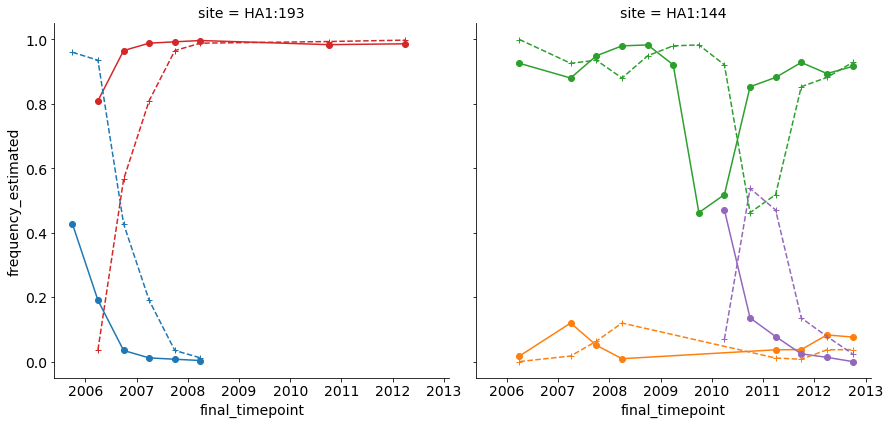

In [183]:
g = sns.FacetGrid(observed_and_predicted_mutations[observed_and_predicted_mutations["site"].isin(sites_to_plot)],
                  hue="residue", col="site", col_wrap=4, height=6)
g.map(plt.plot, "timepoint", "frequency_observed", marker="o")
g.map(plt.plot, "final_timepoint", "frequency_estimated", marker="+", linestyle="--")

In [184]:
observed_and_predicted_mutations.head()

,timepoint,site,residue,mutation,frequency_observed,frequency_estimated,final_timepoint
0,2005-10-01,HA1:124,N,HA1:124N,0.025933,0.020989,2005-10-01
1,2005-10-01,HA1:124,S,HA1:124S,0.974030,0.979011,2005-10-01
2,2005-10-01,HA1:138,A,HA1:138A,0.970997,0.912624,2005-10-01
3,2005-10-01,HA1:138,S,HA1:138S,0.029000,0.087376,2005-10-01
4,2005-10-01,HA1:145,K,HA1:145K,0.006537,0.250963,2005-10-01


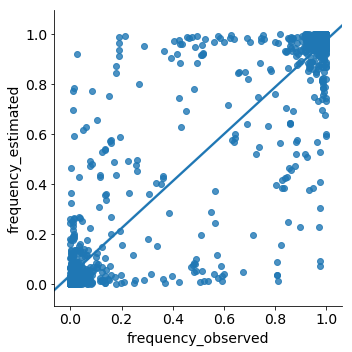

In [185]:
sns.lmplot("frequency_observed", "frequency_estimated", observed_and_predicted_mutations)

## Inspect cTiterSub model

In [ ]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [ ]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

In [ ]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("SSE")

In [ ]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("MAE")

## Inspect epitope count model

In [186]:
predictors = ["ep"]

model = MutationExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [187]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y, X_mutations)
    errors.append(error)

Text(0,0.5,'SSE')

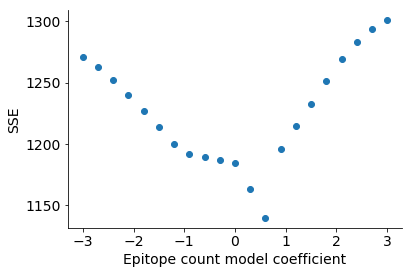

In [188]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'Negative information gain')

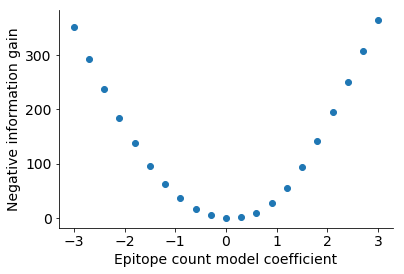

In [189]:
predictors = ["ep"]

model = MutationExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y, X_mutations)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("Negative information gain")

## Inspect epitope cross-immunity model

Text(0,0.5,'SSE')

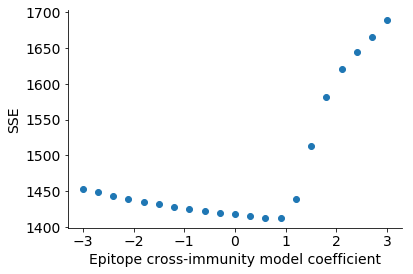

In [96]:
predictors = ["ep_x"]

model = MutationExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y, X_mutations)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'Negative information gain')

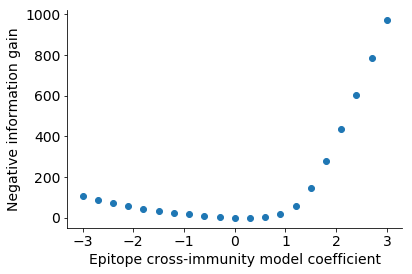

In [97]:
model = MutationExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y, X_mutations)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("Negative information gain")

## Inspect delta frequency model

In [98]:
predictors = ["delta_frequency"]

model = MutationExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

In [99]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y, X_mutations)
    errors.append(error)

Text(0,0.5,'Negative information gain')

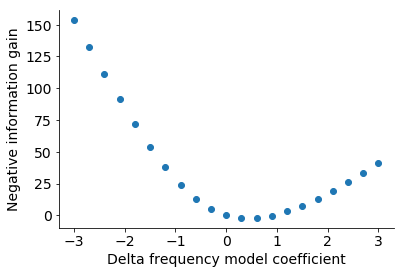

In [100]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Delta frequency model coefficient")
plt.ylabel("Negative information gain")

## Inspect two-parameter models

In [ ]:
predictors = ["lbi", "cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [ ]:
len(coefficients)

In [ ]:
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("SSE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [ ]:
predictors = ["lbi", "cTiterSub_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "cTiterSub": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
records_df = pd.DataFrame(records)
records_df.sort_values("error").head()

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("MAE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

## Minimize negative information gain

Add pseudocounts to current and future tip frequencies.

In [18]:
pseudocount = 1e-6
X_with_pseudocounts = add_pseudocounts_to_frequencies(X, pseudocount)
final_clade_frequencies_with_pseudocounts = add_pseudocounts_to_frequencies(
    final_clade_frequencies,
    pseudocount,
    timepoint_column="initial_timepoint"
)

In [19]:
y_with_pseudocounts = final_clade_frequencies_with_pseudocounts.groupby([
    "initial_timepoint",
    "clade_membership"
])["frequency"].sum().reset_index()

y_with_pseudocounts = y_with_pseudocounts.rename(
    columns={"initial_timepoint": "timepoint"}
)

#y_with_pseudocounts = y_with_pseudocounts[y_with_pseudocounts["timepoint"] <= last_timepoint]

In [20]:
X_with_pseudocounts.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency
0,A/BacGiang/BG003/2004,3a81d99,2004-10-01,NaN,-0.947616,10,-3.021977,6,-1.093891,0.001207
1,A/Hanoi/HN30130/2004,3a81d99,2004-10-01,NaN,-0.918210,10,-3.021977,6,-1.093891,0.000557
2,A/Hanoi/HN30135/2004,3a81d99,2004-10-01,NaN,-0.923689,10,-3.021977,6,-1.093891,0.000646
3,A/California/7/2004,44f9b1f,2004-10-01,-6.794363,1.584951,14,-2.273476,7,0.155149,0.013619
4,A/California/NHRC0002/2003,bee4aad,2004-10-01,NaN,0.142304,10,-2.995527,6,-0.390112,0.000006


In [21]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,3a81d99,2005-10-01,A/Hanoi/ISBM16/2005,0.006537
1,2004-10-01,44f9b1f,2005-10-01,NaN,0.000000
2,2004-10-01,bee4aad,2005-10-01,NaN,0.000000
3,2004-10-01,7aa732d,2005-10-01,A/Auckland/616/2005,0.008753
4,2004-10-01,7aa732d,2005-10-01,A/Auckland/617/2005,0.008971


In [22]:
final_clade_frequencies_with_pseudocounts.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,3a81d99,2005-10-01,A/Hanoi/ISBM16/2005,6.537595e-03
1,2004-10-01,44f9b1f,2005-10-01,NaN,9.999380e-07
2,2004-10-01,bee4aad,2005-10-01,NaN,9.999380e-07
3,2004-10-01,7aa732d,2005-10-01,A/Auckland/616/2005,8.752470e-03
4,2004-10-01,7aa732d,2005-10-01,A/Auckland/617/2005,8.970456e-03


In [23]:
y_with_pseudocounts.head()

,timepoint,clade_membership,frequency
0,2004-10-01,089c686,9.999380e-07
1,2004-10-01,094757b,9.999380e-07
2,2004-10-01,1523083,9.999380e-07
3,2004-10-01,1cfb9ff,9.999380e-07
4,2004-10-01,1dcd826,9.999380e-07


Training error for coefficients [-3.0]: 62.07117046072003
Training error for coefficients [-2.7]: 54.349008019085026
Training error for coefficients [-2.4]: 46.77811222596032
Training error for coefficients [-2.1]: 39.3978696216496
Training error for coefficients [-1.8]: 32.2621146765771
Training error for coefficients [-1.5]: 25.443049887431897
Training error for coefficients [-1.2000000000000002]: 19.03399749254337
Training error for coefficients [-0.8999999999999999]: 13.14948121946783
Training error for coefficients [-0.6000000000000001]: 7.921631346442259
Training error for coefficients [-0.30000000000000027]: 3.4923203905983744
Training error for coefficients [0.0]: 5.735060732370406e-15
Training error for coefficients [0.2999999999999998]: -2.4385900596820047
Training error for coefficients [0.5999999999999996]: -3.7475112185312054
Training error for coefficients [0.8999999999999999]: -3.9057992667363868
Training error for coefficients [1.2000000000000002]: -2.953407563545137
Tr

Text(0,0.5,'Negative information gain')

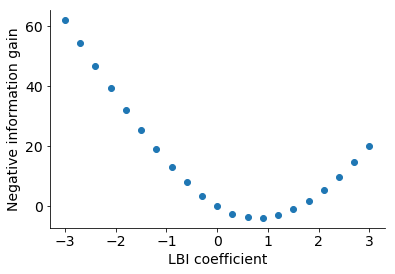

In [24]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X_with_pseudocounts, y_with_pseudocounts)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("Negative information gain")

Training error for coefficients [-3.0]: 22.93464487042579
Training error for coefficients [-2.7]: 18.756974453399803
Training error for coefficients [-2.4]: 14.94930976756871
Training error for coefficients [-2.1]: 11.5359901880372
Training error for coefficients [-1.8]: 8.541422123862949
Training error for coefficients [-1.5]: 5.98544400388202
Training error for coefficients [-1.2000000000000002]: 3.880703377247434
Training error for coefficients [-0.8999999999999999]: 2.2324913037716927
Training error for coefficients [-0.6000000000000001]: 1.0398139396020427
Training error for coefficients [-0.30000000000000027]: 0.2972881456632282
Training error for coefficients [0.0]: 5.735060732370406e-15
Training error for coefficients [0.2999999999999998]: 0.15762894526401489
Training error for coefficients [0.5999999999999996]: 0.8371178527864935
Training error for coefficients [0.8999999999999999]: 2.270169798714513
Training error for coefficients [1.2000000000000002]: 4.9098722684955245
Trai

Text(0,0.5,'Negative information gain')

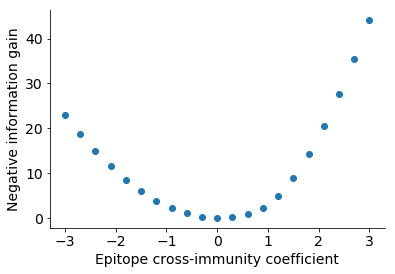

In [25]:
predictors = ["ep_x"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X_with_pseudocounts, y_with_pseudocounts)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity coefficient")
plt.ylabel("Negative information gain")

Training error for coefficients [-3.0]: 22.883149176893195
Training error for coefficients [-2.7]: 18.717033844760582
Training error for coefficients [-2.4]: 14.919242109862934
Training error for coefficients [-2.1]: 11.51426037857541
Training error for coefficients [-1.8]: 8.526586278840888
Training error for coefficients [-1.5]: 5.976121838959449
Training error for coefficients [-1.2000000000000002]: 3.8755767229420988
Training error for coefficients [-0.8999999999999999]: 2.2303139845116005
Training error for coefficients [-0.6000000000000001]: 1.0394203510838547
Training error for coefficients [-0.30000000000000027]: 0.29759487212222635
Training error for coefficients [0.0]: -3.8634528869302445e-06
Training error for coefficients [0.2999999999999998]: 0.15633802640352773
Training error for coefficients [0.5999999999999996]: 0.8334669423994341
Training error for coefficients [0.8999999999999999]: 2.2626016506512605
Training error for coefficients [1.2000000000000002]: 4.895756981366

Text(0,0.5,'Negative information gain')

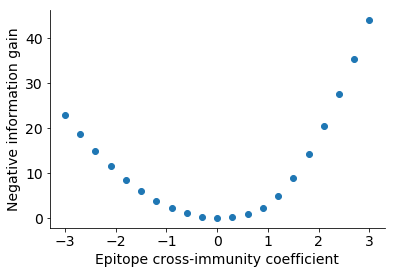

In [26]:
predictors = ["ep_x"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity coefficient")
plt.ylabel("Negative information gain")

In [27]:
predictors = ["lbi", "ep_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X_with_pseudocounts, y_with_pseudocounts)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "ep_x": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

Training error for coefficients [-3.0, -3.0]: 100.20858034238022
Training error for coefficients [-3.0, -2.7]: 94.88115178353684
Training error for coefficients [-3.0, -2.4]: 89.83308343913856
Training error for coefficients [-3.0, -2.1]: 85.07415713993974
Training error for coefficients [-3.0, -1.8]: 80.62085578658875
Training error for coefficients [-3.0, -1.5]: 76.49638622804389
Training error for coefficients [-3.0, -1.2000000000000002]: 72.73071704063906
Training error for coefficients [-3.0, -0.8999999999999999]: 69.36067166021121
Training error for coefficients [-3.0, -0.6000000000000001]: 66.4288979421243
Training error for coefficients [-3.0, -0.30000000000000027]: 63.98117046735106
Training error for coefficients [-3.0, 0.0]: 62.07117046072003
Training error for coefficients [-3.0, 0.2999999999999998]: 60.8107520246768
Training error for coefficients [-3.0, 0.5999999999999996]: 60.53060606933494
Training error for coefficients [-3.0, 0.8999999999999999]: 61.853781941650865
Tr

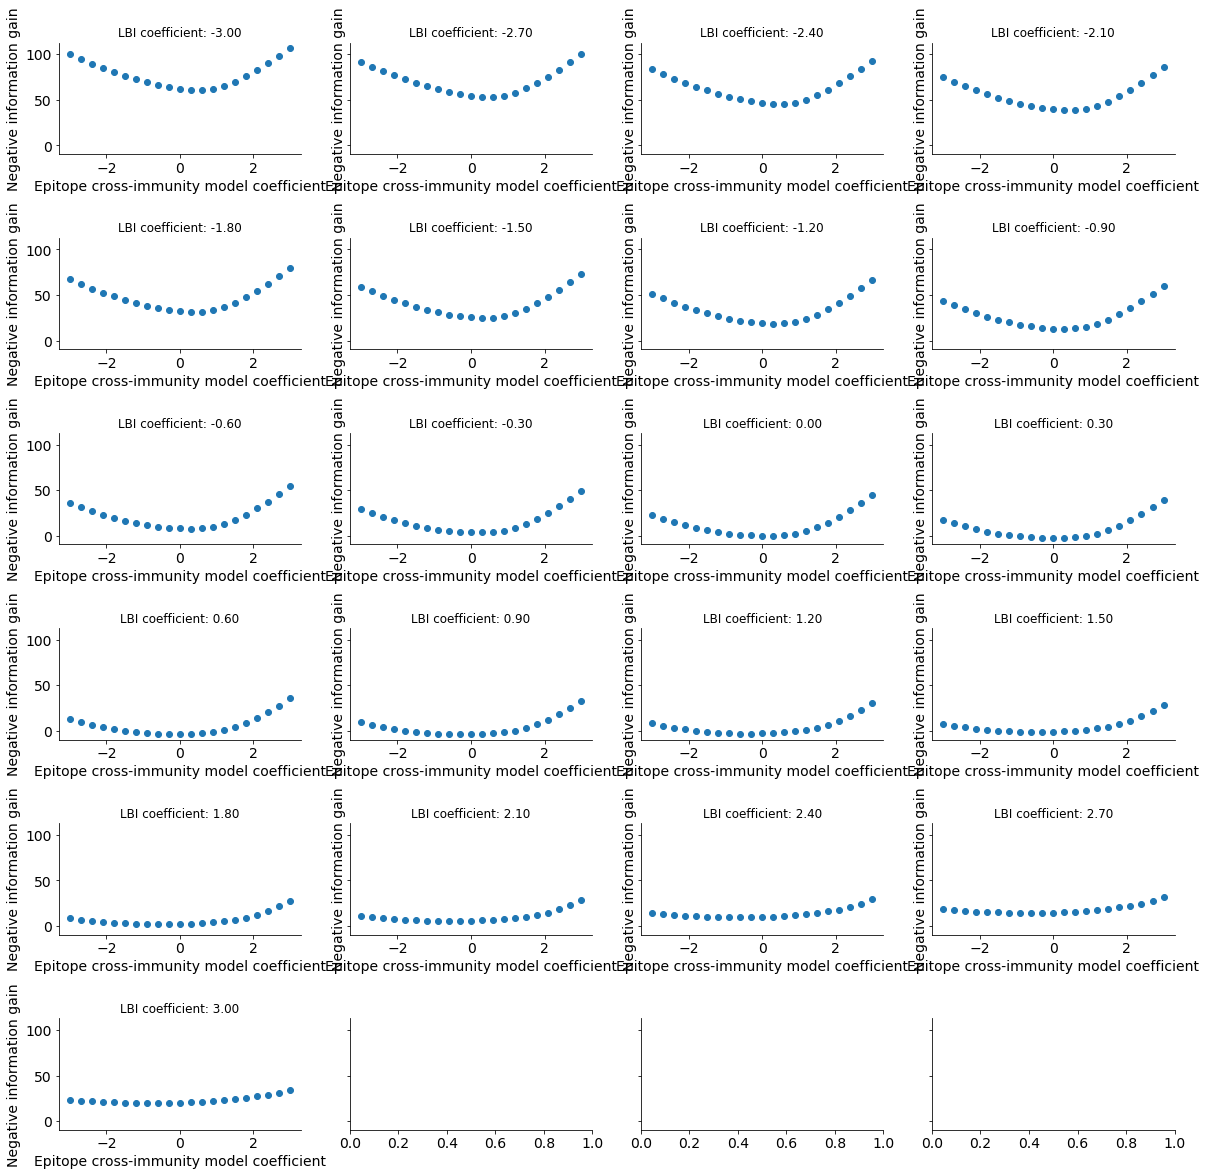

In [28]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Epitope cross-immunity model coefficient")
    ax.set_ylabel("Negative information gain")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [29]:
records_df = pd.DataFrame(records)
records_df.sort_values("error").head()

,ep_x,error,lbi
282,-0.3,-4.017556,0.9
283,0.0,-3.905799,0.9
281,-0.6,-3.821338,0.9
261,-0.3,-3.761840,0.6
262,0.0,-3.747511,0.6
